In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#### dataset

In [2]:
import torchvision 

import torchvision.transforms as transforms 

In [3]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# in the dataset this will be in numbers.. class 0,1,2,.. 

In [4]:
import torch.nn as nn

### LeNet - model

In [6]:
class LeNet(nn.Module):
    
    def __init__(self): 
        super().__init__()

        # make as two parts - a convoln part and a fully connected part
        # as we need a flattening operation in between

        self.cnn_block = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )

        # FC part on flattened version of ouput of Convoln part.
        self.fc_block = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, XX):
        XX = self.cnn_block(XX)
        XX = XX.view(XX.size(0), -1) 
        # flatten using reshaping
        # keep same dimension for first index(here, N) -  everything else collapsed into one second index(with -1).
        XX = self.fc_block(XX)
        return XX

#### Data

In [7]:
batch_size = 128 # power of 2

# training data
# dataset: 
trainset = torchvision.datasets.CIFAR10(root='../data_place/cifar', 
                                        train=True, 
                                        download=False, 
                                        transform=transforms.ToTensor())
# dataloader:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

# test data 
# dataset (train = false)
testset = torchvision.datasets.CIFAR10(root='../data_place/cifar', 
                                       train=False, 
                                       download=False, 
                                       transform=transforms.ToTensor())
# dataloader:
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False)
# shuffle = false - as no point in shuffling test data. only evaluating.

## Moving to GPU.
### move data & model to gpu

### device

In [8]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev

device(type='cuda', index=0)

**don't move the entire dataset to GPU - as they can be very large.**  

**moving data to GPU: do in batch**  
wherever they come -> training, evaluation.

In [9]:
def evaluation(dataloader):
    total, correct = 0, 0
    
    for batch in dataloader:
        input_batch, label_batch = batch
        
        # move data to GPU
        input_batch, label_batch = input_batch.to(dev), label_batch.to(dev)

        #these are to be moved to gpu - becasue will be moving model to GPU
        #input to model.. should also be in gpu
        
        output = lenet_model(input_batch)
        _, pred = torch.max(output.data, 1)
        
        total += label_batch.size(0)
        correct += (pred == label_batch).sum().item()
    return 100 * correct / total

The ".data" field is an old field that is kept for backward compatibility but should not be used anymore as it’s usage is dangerous and can make computations wrong. You should use .detach() and/or with torch.no_grad() instead now.

In [10]:
lenet_model = LeNet().to(dev)

define optimizer after moving model to gpu - so now optimizer in gpu

In [11]:
import torch.optim as optim

In [13]:
# loss

loss_fn = nn.CrossEntropyLoss()

# optmizer

opt = optim.Adam(lenet_model.parameters()) 

Difference between nn.CrossEntropyLoss and nn.functional.cross_entropy   
functional one - do softmax - get probability - and cross entropy loss on that.  
nn - expects already softmax-ed input

#### Train

In [16]:
%%time
epochs = 16

for epoch in range(epochs):

    for i, batch in enumerate(trainloader, 0):

        input_batch, label_batch = batch
        
        # move data to gpu
        input_batch, label_batch = input_batch.to(dev), label_batch.to(dev)
        
        # reset gradient
        opt.zero_grad()
        
        # forward pass
        outputs = lenet_model(input_batch)
        
        # loss
        loss = loss_fn(outputs, label_batch)
        
        # compute gradients
        loss.backward()
        
        # update parameters
        opt.step()
        
    print('Epoch: %d/%d' % (epoch, epochs))

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
CPU times: user 1min 25s, sys: 159 ms, total: 1min 26s
Wall time: 1min 24s


In [17]:
# evaluation after training

print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), 
                                             evaluation(trainloader)))

Test acc: 56.82, Train acc: 66.71


Moving to gpu - model, inputs, outputs - all be in gpu.   
can't have some in gpu and some in cpu.

## Visualisation

In [18]:
# loader of smaller batchsize
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

**next( iter(iterable) )**

In [21]:
images,labels  = next(iter(trainloader))

In [22]:
# function to plot any image in tensor form
# convert to numpy, transpose, plot.

def show_tensor(img):
    np_img = img.numpy() #tensor to numpy
    plt.imshow( np.transpose(np_img, (1, 2, 0)) ) # transpose and show
    plt.show()

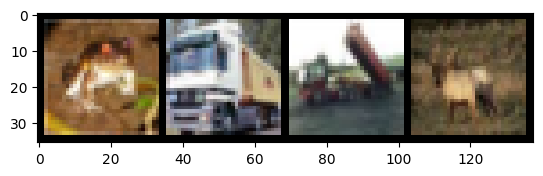

In [23]:
show_tensor(torchvision.utils.make_grid(images))

### can directly move to cpu - like below(device object not needed)

In [24]:
# move model back to cpu

lenet_model = lenet_model.to('cpu') 
# weights, etc. moved to cpu.
# parameters are in the model(model object)  

# doing inference in cpu
# data is in cpu

#### both(data, model) must be in the same place.

In [25]:
out = lenet_model(images) # output of whole network
print(out.shape)

torch.Size([4, 10])


can see ouput after one layer operation also:

### can access model blocks also .. as they are essentially class attributes

**n-th in a sequential block => can be access using seq_name[n]**

In [26]:
# cnn_model is the sequantial we defined. index -> corresponding 

out = lenet_model.cnn_block[0](images) # first conv layer - applying that alone to image
out.shape

torch.Size([4, 6, 28, 28])

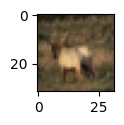

In [28]:
image_id = 3
plt.figure(figsize = (1,1))
show_tensor(images[image_id,])

#### plotting feature maps 

**"output" after that layer**

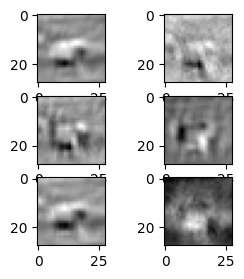

In [29]:
# plotting all the six feature maps of above image in first conv layer.

plt.figure(figsize = (3,3))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    
    plt.imshow( out[image_id, i, :, :].detach().numpy(), cmap="binary" ) 
    #N c x y - i at c position

plt.show()

each kernel is trying to do different things.